In [ ]:
import os
from sklearn.model_selection import train_test_split

import torch
import cv2
import numpy as np
from torch.utils.data import Dataset
from torch.autograd import Variable
from PIL import Image
#from mypath import Path


class SampleDataset(Dataset):
    r"""A Dataset for a folder of videos. Expects the directory structure to be
    directory->[train/val/test]->[class labels]->[videos]. Initializes with a list
    of all file names, along with an array of labels, with label being automatically
    inferred from the respective folder names.
        Args:
            dataset (str): Name of dataset. Defaults to 'ucf101'.
            split (str): Determines which folder of the directory the dataset will read from. Defaults to 'train'.
            clip_len (int): Determines how many frames are there in each clip. Defaults to 16.
            preprocess (bool): Determines whether to preprocess dataset. Default is False.
    """

    def __init__(self, dataset='ucf101', split='train', clip_len=16, preprocess=False,transforms=None):
        self.root_dir, self.output_dir = Path.db_dir(dataset)
        self.splitDir=split
        print(self.splitDir)
        print(self.root_dir)
        folder = os.path.join(self.output_dir, split)
        self.clip_len = clip_len
        self.split = split
        # The following three parameters are chosen as described in the paper section 4.1
        self.resize_height = 128
        self.resize_width = 171
        self.crop_size = 112
        self.transforms=transforms
        if not self.check_integrity():
            raise RuntimeError('Dataset not found or corrupted.' +
                               ' You need to download it from official website.')

        if  preprocess:# and self.check_preprocess():
            print('Preprocessing of {} dataset, this will take long, but it will be done only once.'.format(dataset))
            self.preprocess()

        # Obtain all the filenames of files inside all the class folders
        # Going through each class folder one at a time
        self.fnames, labels = [], []
        for label in sorted(os.listdir(folder)):
            for fname in os.listdir(os.path.join(folder, label)):
                self.fnames.append(os.path.join(folder, label, fname))
                labels.append(label)

        assert len(labels) == len(self.fnames)
        print('Number of {} videos: {:d}'.format(split, len(self.fnames)))

        # Prepare a mapping between the label names (strings) and indices (ints)
        self.label2index = {label: index for index, label in enumerate(sorted(set(labels)))}
        # Convert the list of label names into an array of label indices
        self.label_array = np.array([self.label2index[label] for label in labels], dtype=int)

        if dataset == "ucf101":
            if not os.path.exists('ucf_labels.txt'):
                with open('ucf_labels.txt', 'w') as f:
                    for id, label in enumerate(sorted(self.label2index)):
                        f.writelines(str(id+1) + ' ' + label + '\n')

        elif dataset == 'hmdb51':
            if not os.path.exists('hmdb_labels.txt'):
                with open('hmdb_labels.txt', 'w') as f:
                    for id, label in enumerate(sorted(self.label2index)):
                        f.writelines(str(id+1) + ' ' + label + '\n')


    def __len__(self):
        return len(self.fnames)

    def __getitem__(self, index):
        # Loading and preprocessing.
        labels = np.array(self.label_array[index])
        buffer = self.load_frames(self.fnames[index])
        #buffer=torch.from_numpy(buffer)
        #print("hello",type(buffer))
        buffer = self.crop(buffer, self.clip_len, self.crop_size)
        #print(buffer.shape)
        
        # if self.split == 'test':
        #     # Perform data augmentation
        #     buffer = self.randomflip(buffer)
        # buffer = self.normalize(buffer)
        # buffer = self.to_tensor(buffer)
        if self.transforms:
          sample=torch.zeros(buffer.shape[0],3,112,112)
          #print(type(buffer))
          for i in range(buffer.shape[0]):
            sample[i]=self.transforms(buffer[i])
        return sample, torch.from_numpy(labels)

    def check_integrity(self):
        if  os.path.exists(self.root_dir):
            return True
        else:
            return False

    def check_preprocess(self):
        # TODO: Check image size in output_dir
        if not os.path.exists(self.output_dir):
            return False
        elif not os.path.exists(os.path.join(self.output_dir, self.splitDir)):
            return False

        for ii, video_class in enumerate(os.listdir(os.path.join(self.output_dir, self.splitDir))):
            for video in os.listdir(os.path.join(self.output_dir, self.splitDir, video_class)):
                video_name = os.path.join(os.path.join(self.output_dir, self.split, video_class, video),
                                    sorted(os.listdir(os.path.join(self.output_dir, self.split, video_class, video)))[0])
                image = cv2.imread(video_name)
                if ii%5==0:
                  print("hello",type(image))
                if np.shape(image)[0] != 128 or np.shape(image)[1] != 171:
                    return False
                else:
                    break

            if ii == 10:
                break

        return True

    def preprocess(self):
        if not os.path.exists(self.output_dir):
            os.mkdir(self.output_dir)
            os.mkdir(os.path.join(self.output_dir, 'train'))
            os.mkdir(os.path.join(self.output_dir, 'val'))
            os.mkdir(os.path.join(self.output_dir, 'test'))

        # Split train/val/test sets
        for file in os.listdir(self.splitDir):
            file_path = os.path.join(self.splitDir, file)
            video_files = [name for name in os.listdir(file_path)]

            # train_and_valid, test = train_test_split(video_files, test_size=0.2, random_state=42)
            # train, val = train_test_split(train_and_valid, test_size=0.2, random_state=42)

            # train_dir = os.path.join(self.output_dir, 'train', file)
            # val_dir = os.path.join(self.output_dir, 'val', file)
            # test_dir = os.path.join(self.output_dir, 'test', file)

            # if not os.path.exists(train_dir):
            #     os.mkdir(train_dir)
            # if not os.path.exists(val_dir):
            #     os.mkdir(val_dir)
            # if not os.path.exists(test_dir):
            #     os.mkdir(test_dir)
            directory=os.path.join(self.splitDir,file)
            for video in video_files:
                self.process_video(video, file, directory)

            # for video in val:
            #     self.process_video(video, file, val_dir)

            # for video in test:
            #     self.process_video(video, file, test_dir)

        print('Preprocessing finished.')

    def process_video(self, video, action_name, save_dir):
        # Initialize a VideoCapture object to read video data into a numpy array
        video_filename = video.split('.')[0]
        if not os.path.exists(os.path.join(save_dir, video_filename)):
            os.mkdir(os.path.join(save_dir, video_filename))

        capture = cv2.VideoCapture(os.path.join(self.root_dir, action_name, video))

        frame_count = int(capture.get(cv2.CAP_PROP_FRAME_COUNT))
        frame_width = int(capture.get(cv2.CAP_PROP_FRAME_WIDTH))
        frame_height = int(capture.get(cv2.CAP_PROP_FRAME_HEIGHT))

        # Make sure splited video has at least 16 frames
        EXTRACT_FREQUENCY = 4
        if frame_count // EXTRACT_FREQUENCY <= 16:
            EXTRACT_FREQUENCY -= 1
            if frame_count // EXTRACT_FREQUENCY <= 16:
                EXTRACT_FREQUENCY -= 1
                if frame_count // EXTRACT_FREQUENCY <= 16:
                    EXTRACT_FREQUENCY -= 1

        count = 0
        i = 0
        retaining = True

        while (count < frame_count and retaining):
            retaining, frame = capture.read()
            if frame is None:
                continue

            if count % EXTRACT_FREQUENCY == 0:
                if (frame_height != self.resize_height) or (frame_width != self.resize_width):
                    frame = cv2.resize(frame, (self.resize_width, self.resize_height))
                cv2.imwrite(filename=os.path.join(save_dir, video_filename, '0000{}.jpg'.format(str(i))), img=frame)
                i += 1
            count += 1

        # Release the VideoCapture once it is no longer needed
        capture.release()
        os.remove(os.path.join(save_dir,video))

    def randomflip(self, buffer):
        """Horizontally flip the given image and ground truth randomly with a probability of 0.5."""

        if np.random.random() < 0.5:
            for i, frame in enumerate(buffer):
                frame = cv2.flip(buffer[i], flipCode=1)
                buffer[i] = cv2.flip(frame, flipCode=1)

        return buffer


    def normalize(self, buffer):
        for i, frame in enumerate(buffer):
            frame -= np.array([[[90.0, 98.0, 102.0]]])
            frame=frame/255
            buffer[i] = frame

        return buffer

    def to_tensor(self, buffer):
        return buffer.transpose((3, 0, 1, 2))

    def load_frames(self, file_dir):
        frames = sorted([os.path.join(file_dir, img) for img in os.listdir(file_dir)])
        frame_count = len(frames)
        buffer = np.empty((frame_count, self.resize_height, self.resize_width, 3), np.dtype('uint8'))
        for i, frame_name in enumerate(frames):
            frame = np.array(cv2.imread(frame_name)).astype(np.float64)
            buffer[i] = frame

        return buffer

    def crop(self, buffer, clip_len, crop_size):
        # randomly select time index for temporal jittering
        time_index = np.random.randint(buffer.shape[0] - clip_len)

        # Randomly select start indices in order to crop the video
        height_index = np.random.randint(buffer.shape[1] - crop_size)
        width_index = np.random.randint(buffer.shape[2] - crop_size)

        # Crop and jitter the video using indexing. The spatial crop is performed on
        # the entire array, so each frame is cropped in the same location. The temporal
        # jitter takes place via the selection of consecutive frames
        buffer = buffer[time_index:time_index + clip_len,
                 height_index:height_index + crop_size,
                 width_index:width_index + crop_size, :]

        return buffer

In [ ]:
import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.utils.data import random_split, DataLoader
from torch.optim.lr_scheduler import StepLR
import torchvision
from torchvision import get_video_backend
from torchvision.models.video import r3d_18 
from torchvision import transforms
import os
from tqdm.auto import tqdm
import numpy as np
import time
# import av
import random
# print(f"PyAV version -- {av.__version__}")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
class Path(object):
    @staticmethod
    def db_dir(database):
        if database == 'ucf101':
            # folder that contains class labels
            root_dir = 'video_dataset'

            # Save preprocess data into output_dir
            output_dir = '/content/ucf101Preprocessed/'

            return root_dir, output_dir
        elif database == 'hmdb51':
            # folder that contains class labels
            root_dir = 'video_dataset'

            output_dir = '/content/'

            return root_dir, output_dir
        else:
            print('Database {} not available.'.format(database))
            raise NotImplementedError

    @staticmethod
    def model_dir():
        return 'Models/pretrainedModel1.pth'

In [ ]:
! wget http://serre-lab.clps.brown.edu/wp-content/uploads/2013/10/hmdb51_org.rar
! wget http://serre-lab.clps.brown.edu/wp-content/uploads/2013/10/test_train_splits.rar

--2022-06-01 06:20:24--  http://serre-lab.clps.brown.edu/wp-content/uploads/2013/10/hmdb51_org.rar
Resolving serre-lab.clps.brown.edu (serre-lab.clps.brown.edu)... 128.148.254.114
Connecting to serre-lab.clps.brown.edu (serre-lab.clps.brown.edu)|128.148.254.114|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://serre-lab.clps.brown.edu/wp-content/uploads/2013/10/hmdb51_org.rar [following]
--2022-06-01 06:20:24--  https://serre-lab.clps.brown.edu/wp-content/uploads/2013/10/hmdb51_org.rar
Connecting to serre-lab.clps.brown.edu (serre-lab.clps.brown.edu)|128.148.254.114|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2124008126 (2.0G)
Saving to: ‘hmdb51_org.rar’

hmdb51_org.rar      100%[===================>]   1.98G  67.3MB/s    in 29s     

2022-06-01 06:20:52 (70.5 MB/s) - ‘hmdb51_org.rar’ saved [2124008126/2124008126]

--2022-06-01 06:20:53--  http://serre-lab.clps.brown.edu/wp-content/uploads/2013/10/test_train_splits.rar
R

In [ ]:
! mkdir -p video_dataset test_train_split
! unrar e test_train_splits.rar
! mv *.txt test_train_split
! rm test_train_splits.rar
! unrar e hmdb51_org.rar

! rm hmdb51_org.rar


UNRAR 5.50 freeware      Copyright (c) 1993-2017 Alexander Roshal


Extracting from test_train_splits.rar

Extracting  brush_hair_test_split1.txt                                     0%  OK 
Extracting  brush_hair_test_split2.txt                                     1%  OK 
Extracting  brush_hair_test_split3.txt                                     1%  OK 
Extracting  cartwheel_test_split1.txt                                      2%  OK 
Extracting  cartwheel_test_split2.txt                                      2%  OK 
Extracting  cartwheel_test_split3.txt                                      3%  OK 
Extracting  catch_test_split1.txt                                          4%  OK 
Extracting  catch_test_split2.txt                                          4%  OK 
Extracting  catch_test_split3.txt                                          5%  OK 
Extracting  chew_test_split1.txt                                

In [ ]:
! mv *.rar video_dataset
import os
for files in os.listdir('video_dataset'):
    foldername = files.split('.')[0]
    os.system("mkdir -p video_dataset/" + foldername)
    os.system("unrar e video_dataset/"+ files + " video_dataset/"+foldername)

! rm video_dataset/*.rar

In [ ]:
def get_class_Ind():
    path=os.listdir('video_dataset')
    path.sort()
    return path


def get_train_list(path):#,split='_test_split1'):
    for k in range(1,4):
      trainListName='train_list'+str(k)+'.txt'
      testListName='test_list'+str(k)+'.txt'
      train_list=open(trainListName,'w+')
      test_list=open(testListName,'w+')
      split='_test_split'+str(k)
      for i in range(len(path)):
          file_name=path[i]+split
          file_name='test_train_split/'+file_name+'.txt'
          with open(file_name) as file:
              path_list=[row.strip() for row in list(file)]
              file_path_list = [row.split(' ')[0] for row in path_list]
              file_label_list = [row.split(' ')[1] for row in path_list]
              for j in range(len(file_path_list)):
                  if file_label_list[j]=='1':
                      string_name=path[i]+'/'+file_path_list[j]+' '+str(i)
                      train_list.write(string_name)
                      train_list.write('\n')
                  if file_label_list[j]=='2':
                      string_name=path[i]+'/'+file_path_list[j]+' '+str(i)
                      test_list.write(string_name)
                      test_list.write('\n')
                      
      train_list.close()
      test_list.close()

In [ ]:
path=get_class_Ind()
get_train_list(path)

In [ ]:
import shutil
def createTrainDirectory(path):
  os.mkdir('train')
  with open(path) as file:
    fileList=[row.strip() for row in list(file)]
    dirList=[row.split('/')[0]for row in fileList]
    videoFile=[(row.split('/')[1]).split(' ')[0]for row in fileList]
    labels=[(row.split('/')[1]).split(' ')[1]for row in fileList]
    for i in range (len(fileList)):
      trainDir=os.path.join('train',dirList[i])
      if not os.path.exists(trainDir):
        os.mkdir(trainDir)
      src='video_dataset/'+dirList[i]+'/'+videoFile[i]
      dest=trainDir
      shutil.copy2(src,dest)


In [ ]:
def createTestDirectory(path):
  num=path.split('.')[0][-1]
  dir='test'+str(num)
  os.mkdir(dir)
  with open(path) as file:
    fileList=[row.strip() for row in list(file)]
    dirList=[row.split('/')[0]for row in fileList]
    videoFile=[(row.split('/')[1]).split(' ')[0]for row in fileList]
    labels=[(row.split('/')[1]).split(' ')[1]for row in fileList]
    for i in range (len(fileList)):
      testDir=os.path.join(dir,dirList[i])
      if not os.path.exists(testDir):
        os.mkdir(testDir)
      src='video_dataset/'+dirList[i]+'/'+videoFile[i]
      dest=testDir
      shutil.copy2(src,dest)

In [ ]:
createTrainDirectory('train_list1.txt')

In [ ]:
for i in range(1,4):
  path='test_list'+str(i)+'.txt'
  createTestDirectory(path)

In [ ]:
class AddGaussianNoise(object):
    def __init__(self, noise):
        self.noise=noise
        
    def __call__(self, tensor):
        return tensor + 1.75*torch.permute(torch.from_numpy(noise),(2,0,1))
    
    def __repr__(self):
        return self.__class__.__name__ #+ '(mean={0}, std={1})'.format(self.mean, self.std)

In [ ]:
#done to save the noise in the drive and then load this noise to add in each and every frame
noise=np.random.normal(0,1,(112,112,3))
print(noise.shape)
#noise=np.reshape(self.noise,(self.crop_size,self.crop_size,3))
with open('/content/drive/MyDrive/Colab Notebooks/Colab Notebooks/noise1.npy','wb') as f:
  np.save(f,noise)
        

(112, 112, 3)


In [ ]:
print(noise)

[[[-0.18296944 -0.17042447 -1.80734015]
  [ 0.62422069  1.45661166  0.46554366]
  [-0.78298223 -1.34610745 -1.20787848]
  ...
  [ 0.02159485 -0.29077551 -1.51750611]
  [ 0.77634112  0.45378642  0.05100017]
  [-1.31411435  2.40577177  0.67939471]]

 [[ 0.78875213  0.79629645 -0.94032814]
  [-0.82038165  0.41009942 -0.09101015]
  [-0.46783205  0.79430721 -2.09049051]
  ...
  [-0.96082582 -1.06597132  1.37765176]
  [-1.09893897  0.80097261 -0.4972437 ]
  [-0.82204762 -0.85932305  0.48849449]]

 [[-0.53826452 -0.20389237  1.25935003]
  [ 1.78558797  0.33573598 -0.60713832]
  [ 0.81176715 -2.60200067  1.0210804 ]
  ...
  [ 1.42944694  0.24363937 -0.97790922]
  [-0.13666693  0.41830274 -0.73168451]
  [ 0.76821832 -1.02059971 -0.50056136]]

 ...

 [[ 1.09960685 -0.43793262  1.04801147]
  [ 0.4788837  -1.61604761  0.50807247]
  [-0.66139768  0.16440972 -1.23777476]
  ...
  [ 0.56900967  0.78559967  0.95977583]
  [ 0.72040483  1.77542358 -0.18280191]
  [-0.27093827 -0.2636925   0.71163178]]

 [

In [ ]:
noise=np.load('/content/drive/MyDrive/Colab Notebooks/Colab Notebooks/noise1.npy')
print(noise.shape)
noise_train_transforms=torchvision.transforms.Compose([transforms.ToTensor(),
                                                       transforms.CenterCrop(112),
                                                       transforms.RandomHorizontalFlip(p=0.5),
                                                       transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
                                                        , AddGaussianNoise(noise)
                                                       ])
noise_test_transforms=torchvision.transforms.Compose([transforms.ToTensor(),
                                                       transforms.CenterCrop(112),
                                                       #transforms.RandomHorizontalFlip(p=0.5),
                                                       transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
                                                        , AddGaussianNoise(noise)
                                                       ])

(112, 112, 3)


In [ ]:
dataset='hmdb51'

train_dataloader = DataLoader(SampleDataset(dataset=dataset, split='train',clip_len=16,transforms=noise_train_transforms,preprocess=True), batch_size=20, shuffle=True, num_workers=2)
test1_dataloader   = DataLoader(SampleDataset(dataset=dataset, split='test1',  clip_len=16,transforms=noise_test_transforms,preprocess=True), batch_size=20, num_workers=2)
test2_dataloader  = DataLoader(SampleDataset(dataset=dataset, split='test2', clip_len=16,transforms=noise_test_transforms,preprocess=True), batch_size=20, num_workers=2)
test3_dataloader= DataLoader(SampleDataset(dataset=dataset, split='test3',clip_len=16,transforms=noise_test_transforms,preprocess=True), batch_size=20, shuffle=False, num_workers=2)
#train_dataloader2= DataLoader(SampleDataset(dataset=dataset, split='train',clip_len=16,transforms=train_transforms), batch_size=20, shuffle=False, num_workers=2)

train
video_dataset
Preprocessing of hmdb51 dataset, this will take long, but it will be done only once.
Preprocessing finished.
Number of train videos: 3570
test1
video_dataset
Preprocessing of hmdb51 dataset, this will take long, but it will be done only once.
Preprocessing finished.
Number of test1 videos: 1530
test2
video_dataset
Preprocessing of hmdb51 dataset, this will take long, but it will be done only once.
Preprocessing finished.
Number of test2 videos: 1530
test3
video_dataset
Preprocessing of hmdb51 dataset, this will take long, but it will be done only once.
Preprocessing finished.
Number of test3 videos: 1530


In [ ]:
ModelR21D=torchvision.models.video.r2plus1d_18(pretrained=True) #pretrained=True was not working on 3rd april 2022
print(ModelR21D)

Downloading: "https://download.pytorch.org/models/r2plus1d_18-91a641e6.pth" to /root/.cache/torch/hub/checkpoints/r2plus1d_18-91a641e6.pth


  0%|          | 0.00/120M [00:00<?, ?B/s]

VideoResNet(
  (stem): R2Plus1dStem(
    (0): Conv3d(3, 45, kernel_size=(1, 7, 7), stride=(1, 2, 2), padding=(0, 3, 3), bias=False)
    (1): BatchNorm3d(45, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv3d(45, 64, kernel_size=(3, 1, 1), stride=(1, 1, 1), padding=(1, 0, 0), bias=False)
    (4): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Sequential(
        (0): Conv2Plus1D(
          (0): Conv3d(64, 144, kernel_size=(1, 3, 3), stride=(1, 1, 1), padding=(0, 1, 1), bias=False)
          (1): BatchNorm3d(144, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv3d(144, 64, kernel_size=(3, 1, 1), stride=(1, 1, 1), padding=(1, 0, 0), bias=False)
        )
        (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=Tru

In [ ]:
for param in ModelR21D.parameters(): #//commented on 12 April 2022
  param.requires_grad=False #//commented on 12 April 2022
ModelR21D.fc=nn.Linear(in_features=512,out_features=512)
old_fc=ModelR21D.fc
ModelR21D.fc=nn.Linear(old_fc.in_features,51)
print(ModelR21D)

VideoResNet(
  (stem): R2Plus1dStem(
    (0): Conv3d(3, 45, kernel_size=(1, 7, 7), stride=(1, 2, 2), padding=(0, 3, 3), bias=False)
    (1): BatchNorm3d(45, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv3d(45, 64, kernel_size=(3, 1, 1), stride=(1, 1, 1), padding=(1, 0, 0), bias=False)
    (4): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Sequential(
        (0): Conv2Plus1D(
          (0): Conv3d(64, 144, kernel_size=(1, 3, 3), stride=(1, 1, 1), padding=(0, 1, 1), bias=False)
          (1): BatchNorm3d(144, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv3d(144, 64, kernel_size=(3, 1, 1), stride=(1, 1, 1), padding=(1, 0, 0), bias=False)
        )
        (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=Tru

In [ ]:
device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(len(train_dataloader.dataset))
epochs=100000
print(device)

3570
cuda:0


In [ ]:
#this cell to be run if the model is starting to be trained
epoch_loss=[0]*epochs
epoch_acc=[0]*epochs
epochPsnr=[0]*epochs

In [ ]:
def returnOptimizer():
  lr=1e-3
  nn.init.xavier_uniform_(ModelR21D.fc.weight)
  params_to_update = []
  for name,param in ModelR21D.named_parameters():
      if param.requires_grad == True:
  count=0
  c=0
  for child in ModelR21D.children():
    print('child',count,'is')
    print(child)
    count+=1
    if(count==5):
      for x in child:
        c+=1

        #if c==2:
        for param in x.parameters():
          #param.requires_grad=True
          params_to_update.append(param)
  optimizer = torch.optim.Adam(params_to_update,lr=lr)
  return optimizer

In [ ]:
#to be done after certain number of epochs,when the accuracy reaches certain level after fine tuning
count=0
c=0
for child in ModelR21D.children():
  print('child',count,'is')
  print(child)
  count+=1
  if(count==5):
      for x in child:
        c+=1

        if c==2:
          print('hello',child)

child 0 is
R2Plus1dStem(
  (0): Conv3d(3, 45, kernel_size=(1, 7, 7), stride=(1, 2, 2), padding=(0, 3, 3), bias=False)
  (1): BatchNorm3d(45, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): Conv3d(45, 64, kernel_size=(3, 1, 1), stride=(1, 1, 1), padding=(1, 0, 0), bias=False)
  (4): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): ReLU(inplace=True)
)
child 1 is
Sequential(
  (0): BasicBlock(
    (conv1): Sequential(
      (0): Conv2Plus1D(
        (0): Conv3d(64, 144, kernel_size=(1, 3, 3), stride=(1, 1, 1), padding=(0, 1, 1), bias=False)
        (1): BatchNorm3d(144, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv3d(144, 64, kernel_size=(3, 1, 1), stride=(1, 1, 1), padding=(1, 0, 0), bias=False)
      )
      (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (c

In [ ]:
for param in ModelR21D.parameters():
  print(param.requires_grad)

False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
True
True


In [ ]:

def train1(model,data,lossFunction1,optimizer1,epochs):
  model.to(device)
  
  
  for i in range(starting_epoch,epochs):
    
    running_loss=0
    running_acc=0
    running_psnr=0
    runningValacc=0
    runningValloss=0
    count=0;
    noise=0;
    loss2=0
    loss1=0
    model.train()
    images=[]
    
    for inputs, labels in tqdm(train_dataloader):
      count+=1
      #print("i =",i)
     
      print(inputs.size())
      inputs=Variable(inputs.float()).to(device)

      inputs=torch.permute(inputs,(0,2,1,3,4))
      print(inputs.size())
      labels=Variable(labels).to(device)
      loss=0
      optimizer1.zero_grad()
      outputs=model(inputs)
      prob=nn.Softmax(dim=1)(outputs)
      preds=torch.max(prob,1)[1]
      loss=lossFunction1(outputs,labels)
      
      #print(loss)
      loss.backward()
      optimizer1.step()
      
        #running_psnr+=computePSNR(noisy_img,inputs)
    
      running_loss += loss.item()*inputs.size(0)
      running_acc += torch.sum(preds==labels.data)   
          
    epoch_loss[i]=(running_loss)/len(train_dataloader.dataset)
    epoch_acc[i]=running_acc/len(train_dataloader.dataset)
    # epochPsnr[i]=running_psnr/(len(train_dataloader.dataset)/20)# this can be changed depending on the batch_size
    #scheduler.step()
    torch.save({"model_state_dict":model.state_dict(),
            "losses":epoch_loss,
            "accuracies":epoch_acc,
            "optimization_state_dict":optimizer1.state_dict(),
            "epochs":i},'/content/drive/MyDrive/Colab Notebooks/Colab Notebooks/phase2Exp.pth')
    
    print(epoch_loss)
    print(epoch_acc)
    images.clear()
    count=0
   #validation
    # model.eval()
    # for inputs, labels in tqdm(val_dataloader):
    #   inputs=Variable(inputs).to(device)
    #   labels=Variable(outputs).to(device)
    #   with torch.no_grad():
    #     outputs=model(inputs)
    #     prob=nn.Softmax(dim=1)(outputs)
    #     preds=torch.max(prob,1)[1]
    #     loss=lossFunction(outputs,labels)
    #     runningValloss+=loss.item()*inputs.size(0)
    #     runningValacc+=torch.sum(pred==labels.data())
    # epochValacc=runningValacc/len(val_dataloader.dataset)
    # epochValloss=runningValloss/len(val_dataloader.dataset)
    # print(epochValacc,epochValloss)

    

In [ ]:

# lr=1e-3
# train_params = [{'params': get_1x_lr_params(model), 'lr': lr},
#                      {'params': get_10x_lr_params(model), 'lr': lr * 10}]
loss_fn1=torch.nn.CrossEntropyLoss()
# loss_fn2=meanSigmaLoss()
optimizer1=returnOptimizer()
# optimizer2=returnOptimizer()
scheduler=torch.optim.lr_scheduler.StepLR(step_size=20,optimizer=optimizer1,gamma=0.1)


In [ ]:
#checkpoint means loading saved model, initially starting epoch =0
#initially load the trained model after phase 1 keeping starting_epoch=0 ,then change it to phase2
checkpoint = torch.load('/content/drive/MyDrive/Colab Notebooks/Colab Notebooks/phase1Exp.pth')#,map_location=torch.device('cpu'))
ModelR21D.load_state_dict(checkpoint['model_state_dict'])
#optimizer1.load_state_dict(checkpoint['optimization_state_dict'])

epoch_loss = checkpoint['losses']
epoch_acc=checkpoint['accuracies']
starting_epoch=checkpoint['epochs']+1

# model.eval()

In [ ]:
print(epoch_loss)
print(epoch_acc)
print(starting_epoch)
# print(checkpoint['model_state_dict'])

[3.37146279750156, 2.2421476097756208, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

In [ ]:
starting_epoch=0 #to be saved if training a previously trained model
train1(ModelR21D,train_dataloader,loss_fn1,optimizer1,epochs)

  0%|          | 0/179 [00:00<?, ?it/s]

torch.Size([20, 16, 3, 112, 112])
torch.Size([20, 3, 16, 112, 112])
torch.Size([20, 16, 3, 112, 112])
torch.Size([20, 3, 16, 112, 112])
torch.Size([20, 16, 3, 112, 112])
torch.Size([20, 3, 16, 112, 112])
torch.Size([20, 16, 3, 112, 112])
torch.Size([20, 3, 16, 112, 112])
torch.Size([20, 16, 3, 112, 112])
torch.Size([20, 3, 16, 112, 112])
torch.Size([20, 16, 3, 112, 112])
torch.Size([20, 3, 16, 112, 112])
torch.Size([20, 16, 3, 112, 112])
torch.Size([20, 3, 16, 112, 112])
torch.Size([20, 16, 3, 112, 112])
torch.Size([20, 3, 16, 112, 112])
torch.Size([20, 16, 3, 112, 112])
torch.Size([20, 3, 16, 112, 112])
torch.Size([20, 16, 3, 112, 112])
torch.Size([20, 3, 16, 112, 112])
torch.Size([20, 16, 3, 112, 112])
torch.Size([20, 3, 16, 112, 112])
torch.Size([20, 16, 3, 112, 112])
torch.Size([20, 3, 16, 112, 112])
torch.Size([20, 16, 3, 112, 112])
torch.Size([20, 3, 16, 112, 112])
torch.Size([20, 16, 3, 112, 112])
torch.Size([20, 3, 16, 112, 112])
torch.Size([20, 16, 3, 112, 112])
torch.Size([20

  0%|          | 0/179 [00:00<?, ?it/s]

torch.Size([20, 16, 3, 112, 112])
torch.Size([20, 3, 16, 112, 112])
torch.Size([20, 16, 3, 112, 112])
torch.Size([20, 3, 16, 112, 112])
torch.Size([20, 16, 3, 112, 112])
torch.Size([20, 3, 16, 112, 112])
torch.Size([20, 16, 3, 112, 112])
torch.Size([20, 3, 16, 112, 112])
torch.Size([20, 16, 3, 112, 112])
torch.Size([20, 3, 16, 112, 112])
torch.Size([20, 16, 3, 112, 112])
torch.Size([20, 3, 16, 112, 112])
torch.Size([20, 16, 3, 112, 112])
torch.Size([20, 3, 16, 112, 112])
torch.Size([20, 16, 3, 112, 112])
torch.Size([20, 3, 16, 112, 112])
torch.Size([20, 16, 3, 112, 112])
torch.Size([20, 3, 16, 112, 112])
torch.Size([20, 16, 3, 112, 112])
torch.Size([20, 3, 16, 112, 112])
torch.Size([20, 16, 3, 112, 112])
torch.Size([20, 3, 16, 112, 112])
torch.Size([20, 16, 3, 112, 112])
torch.Size([20, 3, 16, 112, 112])
torch.Size([20, 16, 3, 112, 112])
torch.Size([20, 3, 16, 112, 112])
torch.Size([20, 16, 3, 112, 112])
torch.Size([20, 3, 16, 112, 112])
torch.Size([20, 16, 3, 112, 112])
torch.Size([20

KeyboardInterrupt: ignored

In [ ]:
# for testing
ModelR21D.to(device)
ModelR21D.eval()
predictions=[]
true_labels=[]
testNoisyImages=[]
testImages=[]
c=0

testAcc=0
for inputs,labels in tqdm(test1_dataloader):
  # noise=torch.zeros(inputs.size())
  # noise=noise.normal_(mean=mean,std=sigma)
  # noisy_img=noise+inputs
  inputs=Variable(inputs.float()).to(device)

  inputs=torch.permute(inputs,(0,2,1,3,4))
  labels=Variable(labels).to(device)
  # if(c<=3):
    
  #   testImages.append(inputs)

  
  
  # inputs=Variable(noisy_img.float()).to(device)
  # inputs=torch.permute(inputs,(0,2,1,3,4))
  # if(c<=3):
  #   testNoisyImages.append(inputs)

  true_labels.append(labels)
  c+=1
  preds=torch.max(nn.Softmax(dim=1)(ModelR21D(inputs)),1)[1]
  testAcc+=torch.sum(preds==labels)
  predictions.append(preds)

  0%|          | 0/77 [00:00<?, ?it/s]

In [ ]:
print(predictions)
print(true_labels)

[tensor([29, 29, 38, 44, 36,  0,  0,  0, 22,  0,  0, 36, 16,  0, 39, 26, 39, 10,
        45, 10], device='cuda:0'), tensor([36, 36, 10,  0, 48, 49, 10, 38, 10, 37,  5, 41, 38, 16, 16, 41, 15, 41,
        31, 20], device='cuda:0'), tensor([41, 49,  2, 16, 29,  6, 41, 14, 16, 41, 16, 16, 36, 21, 43, 16, 16, 38,
        49,  2], device='cuda:0'), tensor([ 2, 16, 16,  2,  2,  2, 48, 36, 44,  2, 46,  2, 49, 26,  2,  2,  2,  2,
         2,  2], device='cuda:0'), tensor([ 2,  2,  2,  2,  2,  2, 38,  2, 36,  2, 40,  3, 10, 10, 40, 10, 17, 17,
        46, 17], device='cuda:0'), tensor([39,  3, 40, 48, 49,  6, 22,  3, 38, 10, 17,  0,  3, 46, 40, 17, 46,  3,
        48, 48], device='cuda:0'), tensor([39, 46, 38,  4,  4, 22, 10, 46, 46, 48,  0, 26, 46,  0, 42, 22, 10, 48,
        44, 10], device='cuda:0'), tensor([17,  0, 49, 44, 46, 16, 49, 50, 20, 20,  5, 26, 16, 36, 41, 16,  5, 16,
        26, 35], device='cuda:0'), tensor([36,  5, 16, 36, 41,  8, 46,  5, 26,  8,  5, 49,  5,  5,  5,  5, 41, 16,

In [ ]:
print(testAcc/len(test1_dataloader.dataset))

tensor(0.1941, device='cuda:0')


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


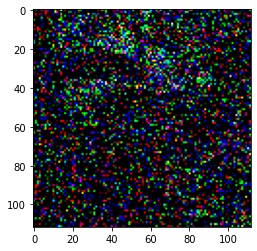

In [ ]:
import matplotlib.pyplot as plt
helloBatch=iter(train_dataloader).next()[0]
firstImg=helloBatch[0][0].numpy().transpose((1,2,0))
plt.imshow(firstImg)
plt.show()

In [ ]:
print(firstImg)

[[[-2.4381006  -2.31645    -4.9498606 ]
  [-1.0255177   0.51335627 -0.98974305]
  [-3.4709983  -4.2863603  -3.831086  ]
  ...
  [-2.080113   -2.4745433  -4.46008   ]
  [-0.75930697 -1.1365459  -1.6977649 ]
  [-4.0579844   2.7871315  -0.11005714]]

 [[-0.73758775 -0.6246885  -3.4325895 ]
  [-3.5364473  -1.2655193  -1.9114246 ]
  [-2.9194853  -0.5406346  -5.375657  ]
  ...
  [-3.799349   -3.831136    0.60644615]
  [-4.041047   -0.5289701  -2.6571918 ]
  [-3.1968675  -2.9267845  -0.4441325 ]]

 [[-3.059867   -2.375019    0.41684735]
  [ 1.006875   -1.4481761  -2.8669364 ]
  [-0.6973114  -6.5191875   0.03473384]
  ...
  [ 0.38362822 -1.5393173  -3.5157855 ]
  [-2.3570712  -1.1986424  -3.0674632 ]
  [-0.39677736 -3.1915116  -2.157551  ]]

 ...

 [[-0.1764673  -2.7845893   0.04700488]
  [-1.2627329  -4.8462906  -0.89788836]
  [-3.2582252  -1.7304903  -3.953121  ]
  ...
  [-0.7796419  -0.04816968  0.52004355]
  [-0.685948    1.4564312  -1.7409055 ]
  [-2.5749214  -2.374627   -0.45451364]]

 [